<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_RegressionLineaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un regression linéaire sur notre série temporelle. Pour cela, nous allons suivre les étapes suivantes :
  - Reprendre le code nécessaire pour créer notre série temporelle
  - Définir une fonction permettant de préparer les données d'entrée X et les labels Y pour attaquer notre réseau de régression linéaire

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Création de la série temporelle

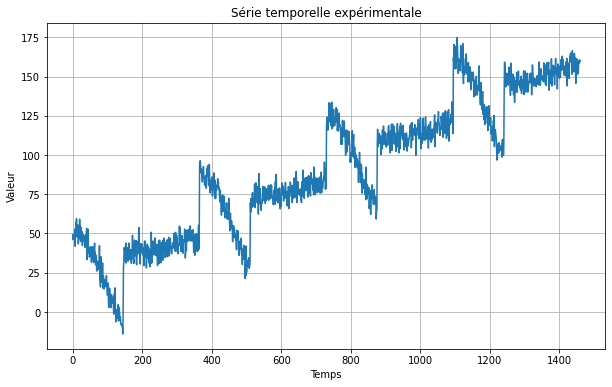

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

Définissons la fonction `fenetrage_Dataset` qui va permettre de créer les données X Y pour le réseau de neurones. Cette fonction retourne une classe Dataset et prend comme  paramètres :
 - `serie` : La série temporelle à traiter
 - `taille_fenetre` : La taille de la fenêtre glissante
 - `batch_size` : La nombre de regroupements que l'on souhaite obtenir dans nos données X et Y : par exemple si X=(X1,X2) et Y=(Y1,Y2) alors il faut donner `batch_size = 2`
 - `buffer_melange` : Buffer pour le mélange des données  
   
Cette fonction utilise la méthode [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) de la classe Dataset de Tensorflow afin d'extraire une coupe depuis la série originale et de créer un dataset qui contient les valeurs de la série :

In [ ]:
print(serie.shape)
dataset = tf.data.Dataset.from_tensor_slices(serie)
for vecteur in dataset:
  print(vecteur.numpy())

In [24]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Regardons un exemple :

In [ ]:
test = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
dataset = prepare_dataset_XY(serie=test,taille_fenetre=3,batch_size=2,buffer_melange=20)
list(dataset.as_numpy_iterator())

# Construction du réseau de régression linéaire

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [32]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Mise en place de la régression linéaire**

On commence par créer notre dataset à partir de la série :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY.png?raw=true" width="1000"> 

In [90]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

Regardons ce qu'on obtient :

In [ ]:
# Affiche le nombre total d'éléments dans le dataset
print("Nombre total d'éléments dans le dataset : %d" %len(list(dataset.as_numpy_iterator())))

# Affiche le premier élément du dataset
n = 0
print("Premier élément dans le dataset :")
for element in dataset:
  print(element)
  n=n+1
  if (n==1): break


On obtient donc un dataset qui contient :
- 45 éléments de dimension 2, chacun est au format (32,20) : Ce sont les paires X
- 45 éléments de dimension 1, chacun est au format (32) : Ce sont les labels Y